# Shallow water equations with a tracer

We can augment the shallow water equations with a tracer $\phi(x,t)$ that measures the concentration of a tracer that is advected with the fluid motion (and that has no influence on the fluid dynamics).  If $\phi$ is measured in units of mass per unit volume (which is really per unit area in this one-dimensional example) then the mass per unit length along the $x$ axis is given by $h(x,t)\phi(x,t)$.  The quantity $\phi$ satisfies the variable coefficient advection equation in advective (non-conservative) form:
$$
\phi_t(x,t) + u(x,t)\phi_x(x,t) = 0.
$$
This is also called the "color equation", since we can think of $\phi$ as measuring the concentration of a dye that changes the color of the water.  We will use this interpretation in the plots below.  By setting the intitial conditions $\phi(x,0)$ to be piecewise constant with different values corresponding to different colors, we can visualize the motion of the fluid better.   We will use two shades of red for the water that is initially to the left of a dam at $x=0$ and two shades of blue for the water that is initially to the right.  

The quantity $h\phi$ satisfies the conservative form of the advection equation,
$$
(h\phi)_t + (uh\phi)_x = 0.
$$
This can be derived by combining the color equation with the conservation of mass equation $h_t +(hu)_x  = 0$.  Since $h\phi$ measures the concentration of dye per unit length in $x$, and we assume molecules of dye are not created or destroyed, it makes sense that this is the conserved quantity.

The full system of equations in conservation form is thus:
$$
\begin{split}
h_t + (hu)_x &=0\\
(hu)_t + \left(hu^2 + \frac 1 2 gh^2\right)_x &=0\\
(h\phi)_t + (uh\phi)_x &= 0
\end{split}
$$

The Riemann solution for this system has 3 waves.  The wave speeds are the eigenvalues of the Jacobian matrix, and are $u-c,~u,~u+c$ where $c = \sqrt{gh}$ is the gravity wave speed.  The 1-wave and 3-wave are the nonlinear shallow water waves, which can be computed as in the shallow water equations using the first two equations of the system alone (since the tracer does not affect the fluid dynamics).  The 2-wave is a contact discontinuity (linearly degenerate wave) moving with the fluid velocity and carrying only a jump in the tracer concentration $\phi$.  The fluid velocity is constant across this wave and so characteristics travel parallel to the wave on either side.  The nonlinear waves can each be either a shock wave or rarefaction wave depending on the initial data.  Below we consider a dam break problem in which case there is one of each.

In [1]:
%matplotlib inline
from clawpack import pyclaw
import matplotlib.pyplot as plt
from matplotlib import animation
from clawpack.visclaw.JSAnimation import IPython_display
from clawpack.riemann import shallow_roe_tracer_1D
depth = 0
momentum = 1
tracer = 2

## Clawpack solution of the dam break problem

In this notebook we use the finite volume methods in Clawpack to illustrate the solution to a Riemann problem.

This allows us to also impose solid wall boundary conditions at the left and right boundaries of the domain and observe the resulting reflection and interaction of the rarefaction wave and shock wave that arise from the Riemann problem.  

In [2]:
solver = pyclaw.ClawSolver1D(shallow_roe_tracer_1D)
solver.num_eqn = 3
solver.num_waves = 3
solver.bc_lower[0] = pyclaw.BC.wall
solver.bc_upper[0] = pyclaw.BC.wall
x = pyclaw.Dimension(-1.0,1.0,2000,name='x')
domain = pyclaw.Domain(x)
state = pyclaw.State(domain,solver.num_eqn)

state.problem_data['grav'] = 1.0

grid = state.grid
xc = grid.p_centers[0]

hl = 1.
hr = 1./3
ul = 0.
ur = 0.

state.q[depth,:] = hl*(xc<=0) + hr*(xc>0)
state.q[momentum,:] = hl*ul*(xc<=0) + hr*ur*(xc>0)
state.q[tracer,:] = xc

claw = pyclaw.Controller()
claw.tfinal = 5
claw.solution = pyclaw.Solution(state,domain)
claw.solver = solver
claw.keep_copy = True
claw.num_output_times = 50
claw.verbosity = 0

claw.run()

{'cflmax': 0.9578561774960984,
 'dtmax': 0.0009000000000000001,
 'dtmin': 0.0007393780749629893,
 'numsteps': 6584}


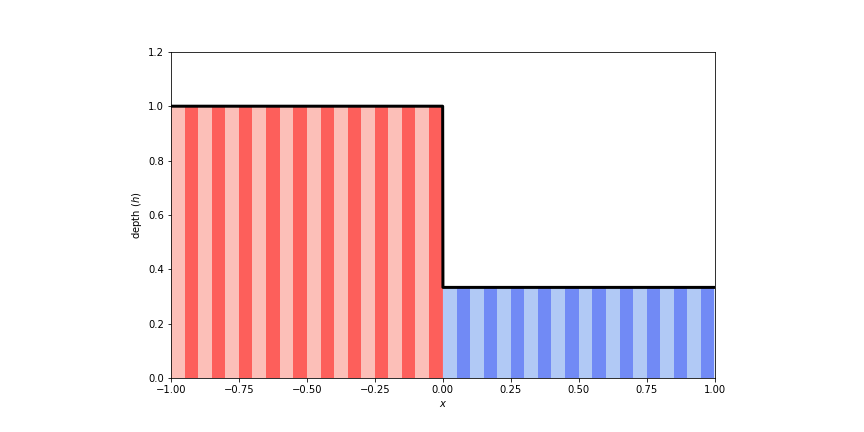
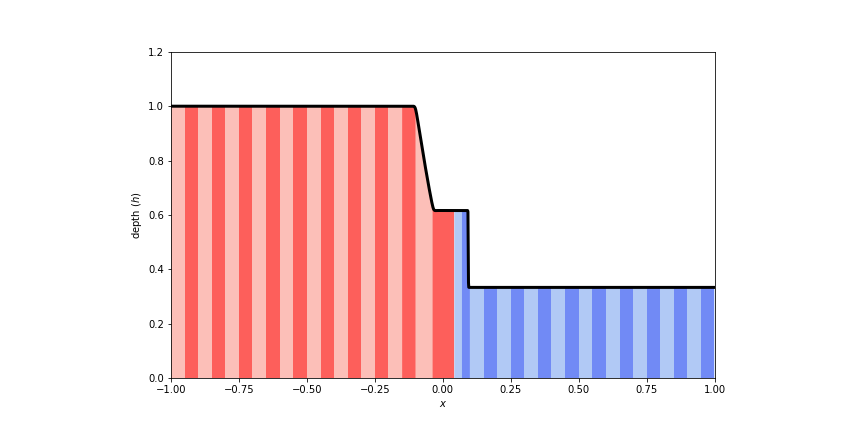
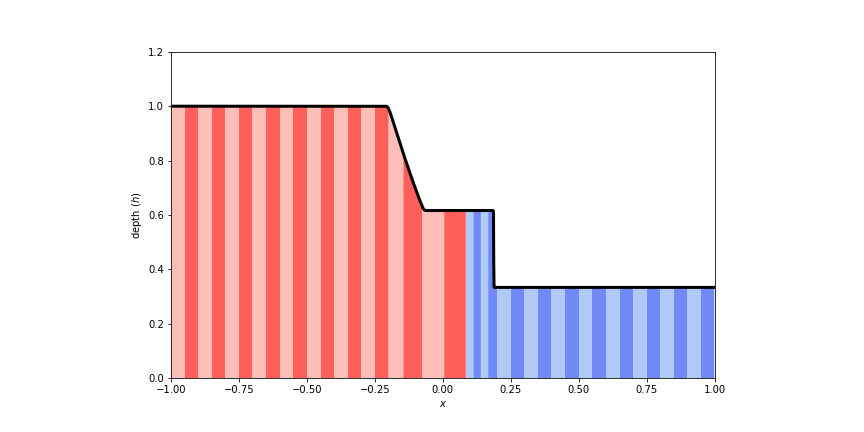
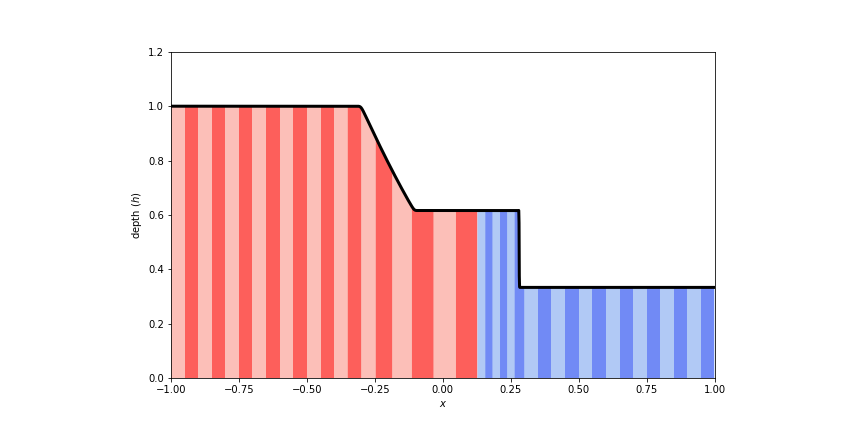
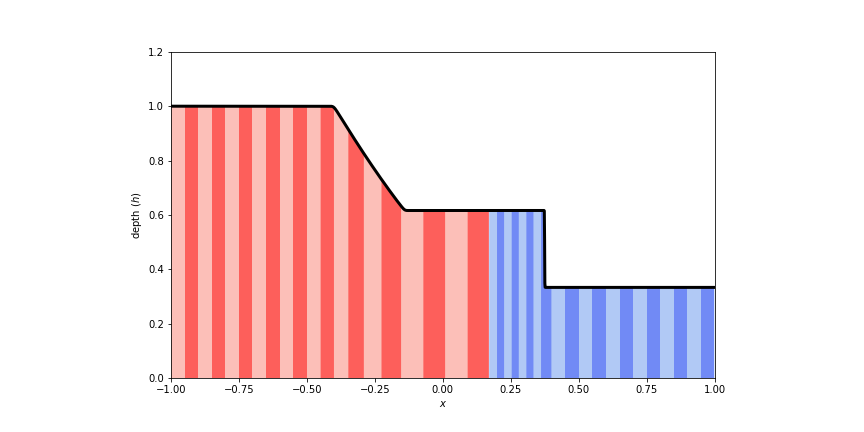
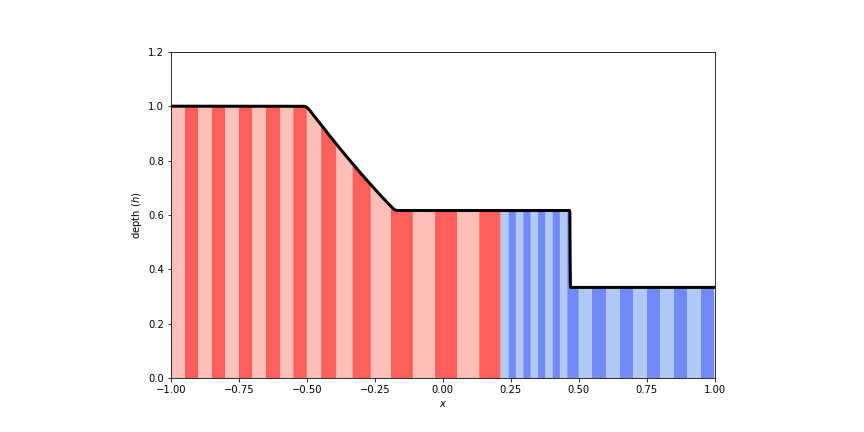
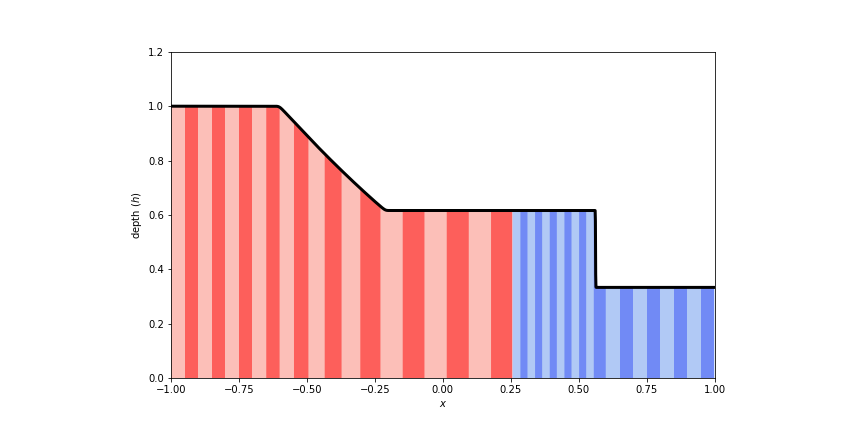
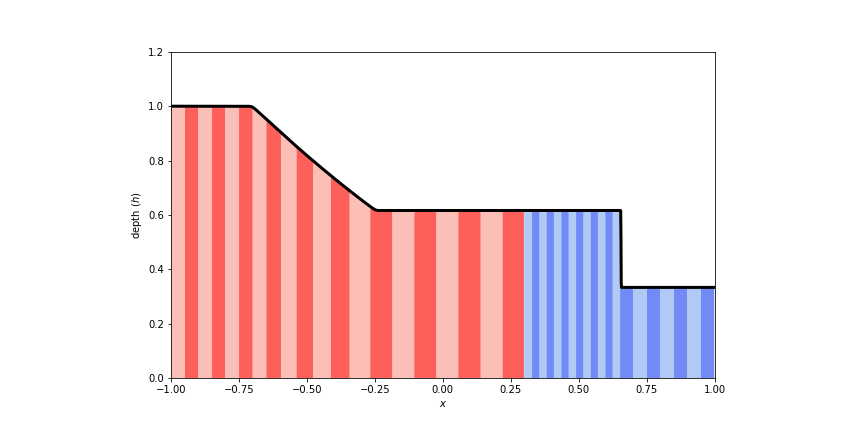
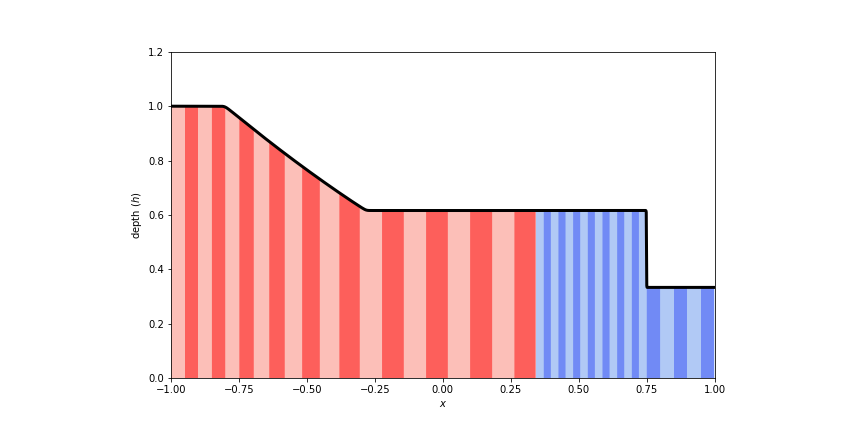
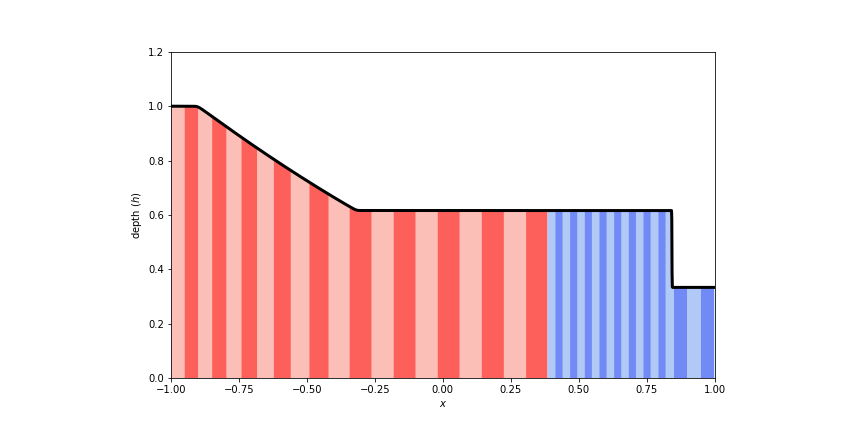
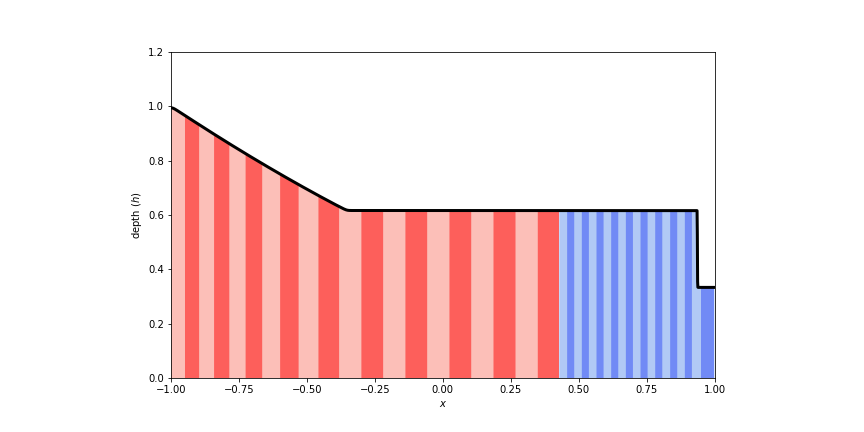
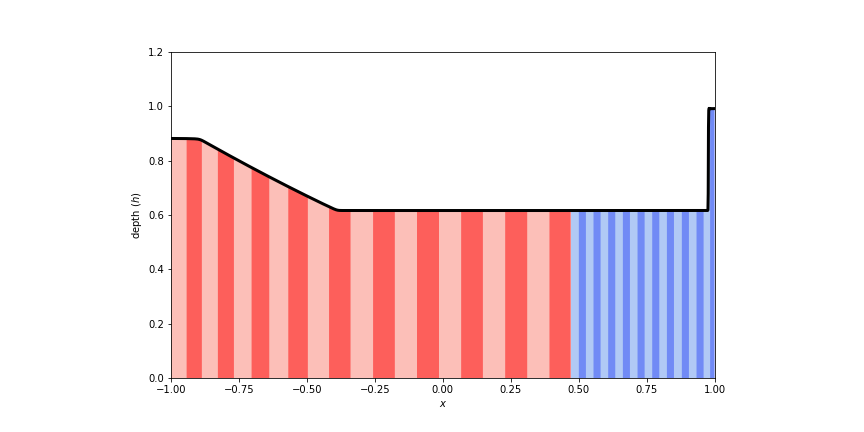
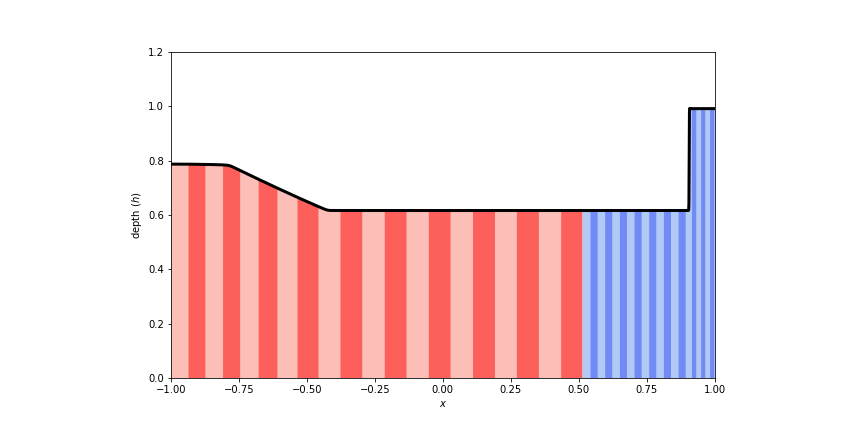
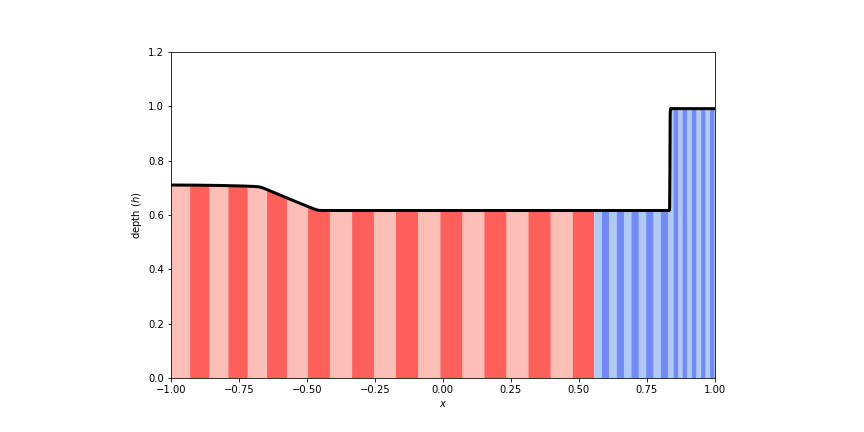
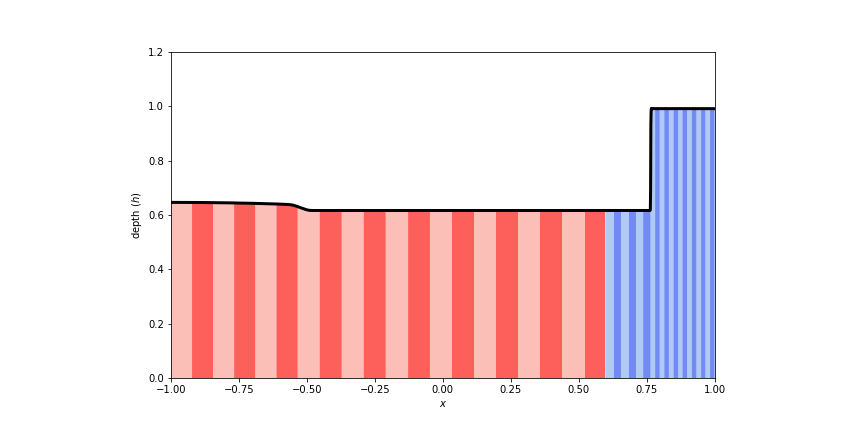
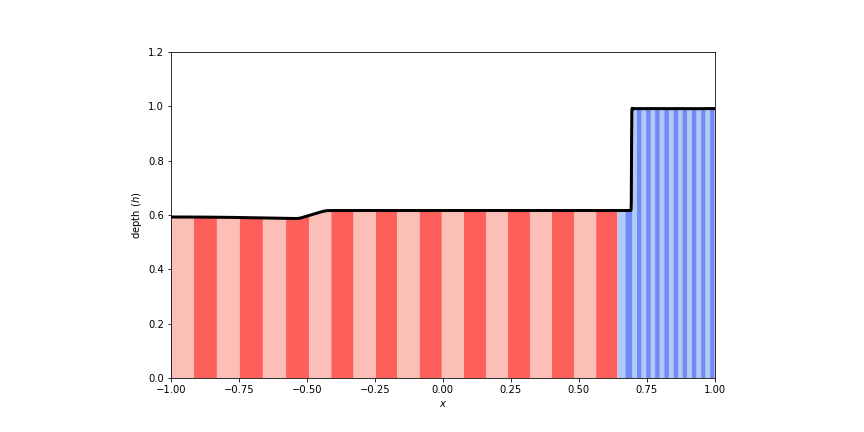
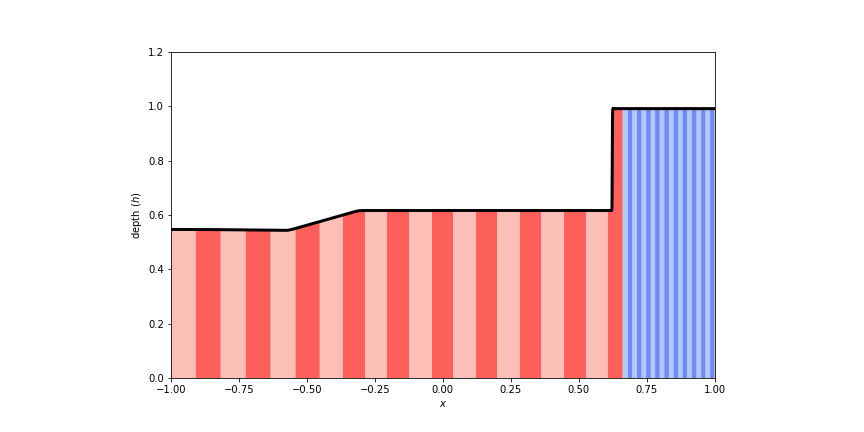
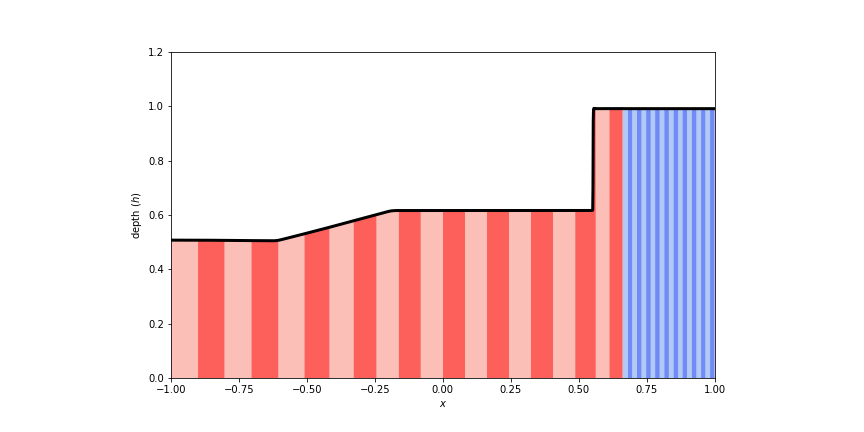
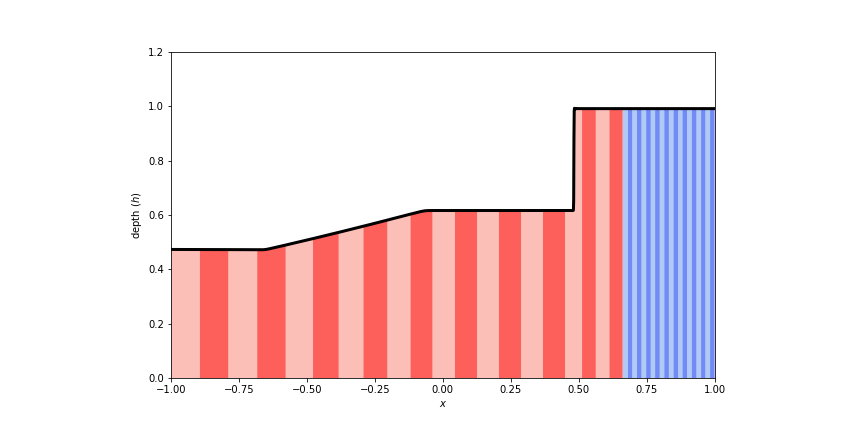
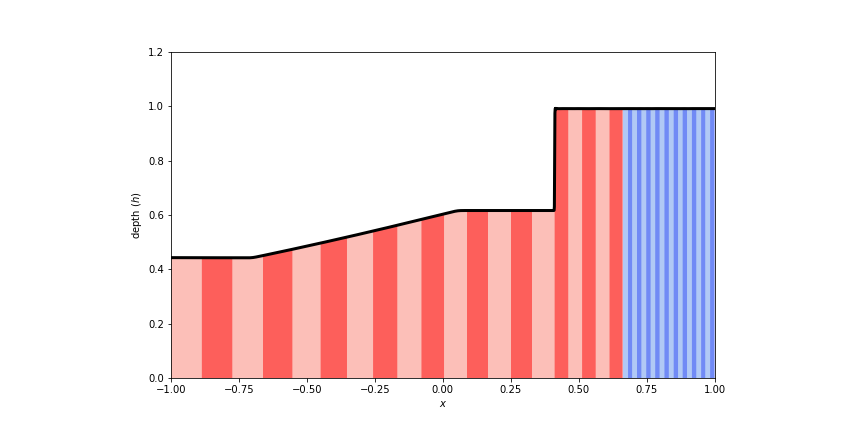
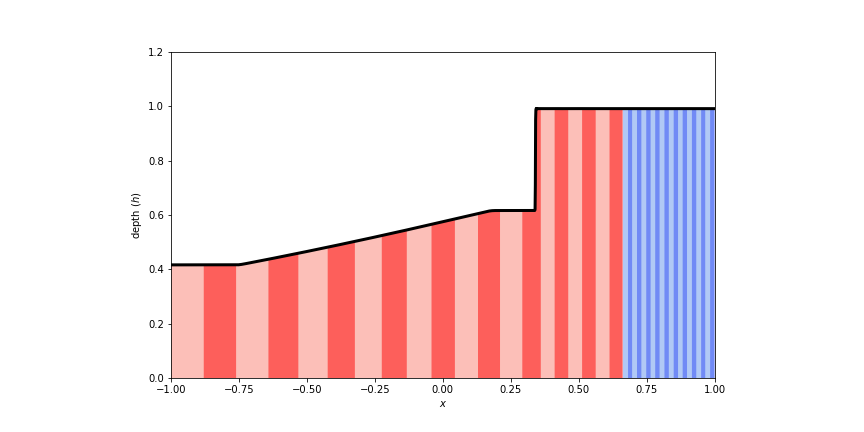
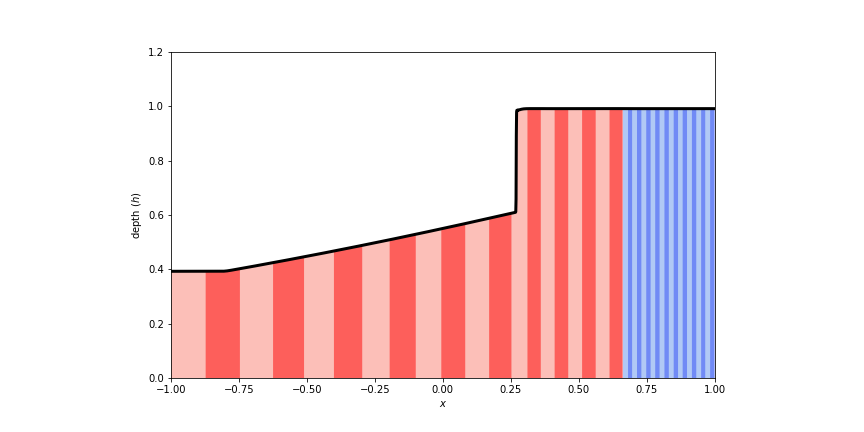
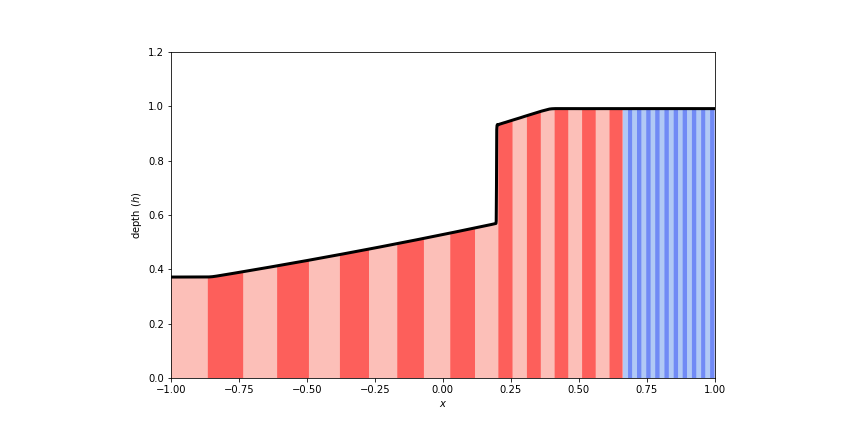
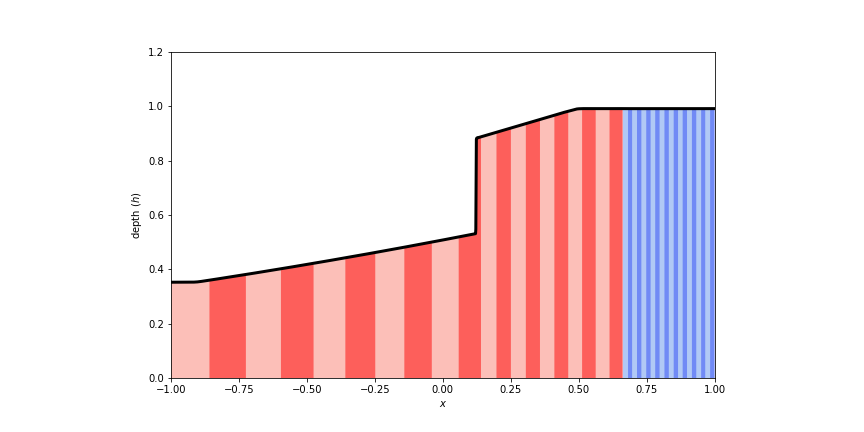
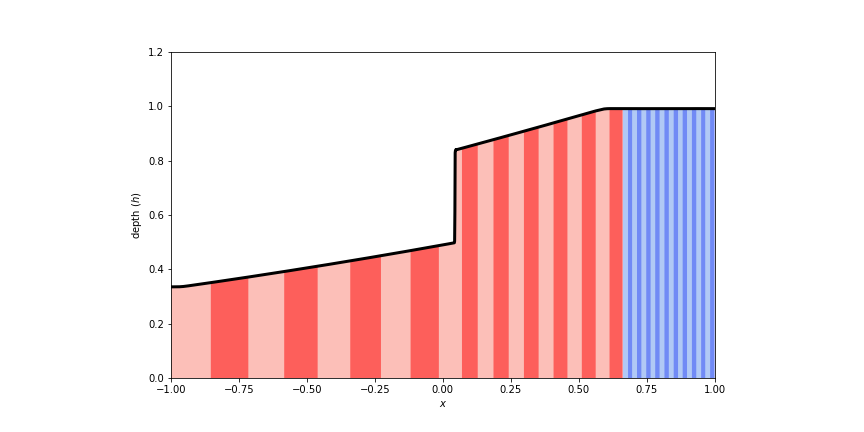
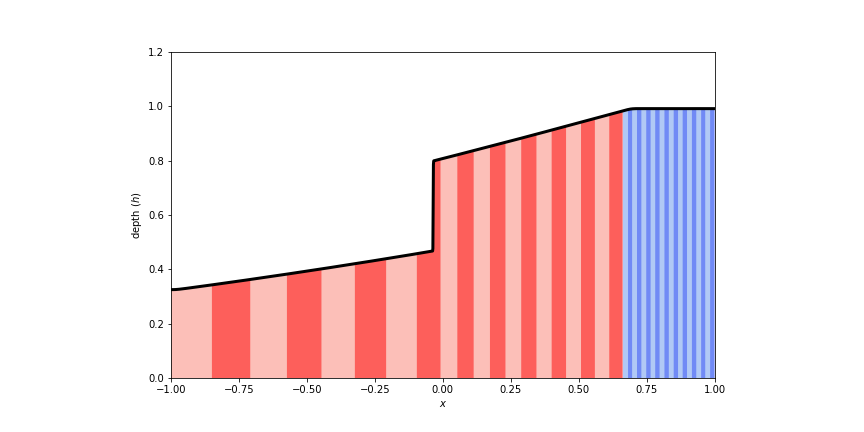
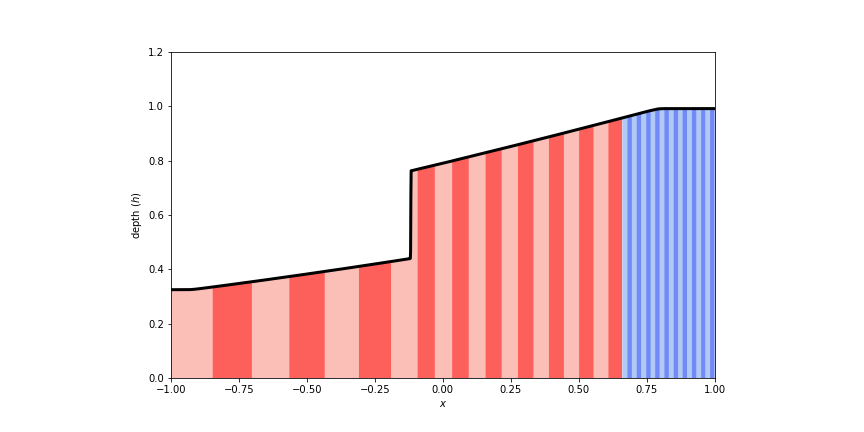
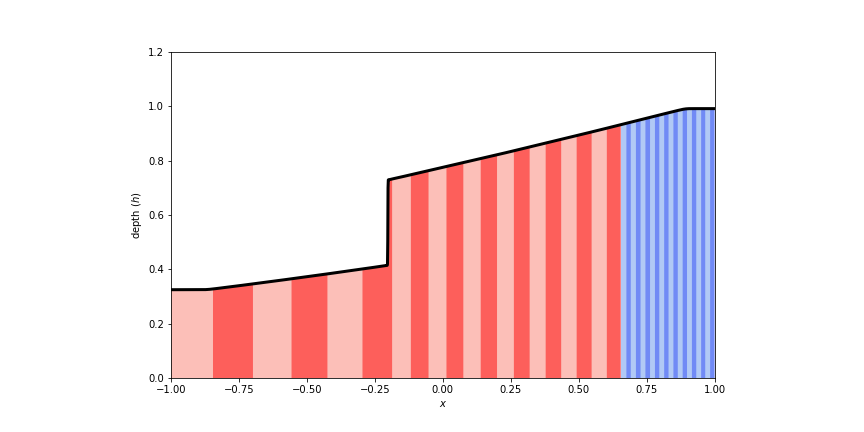
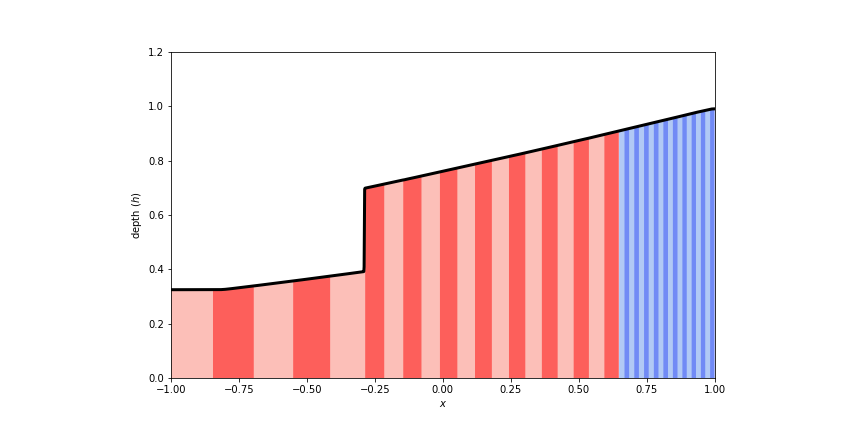
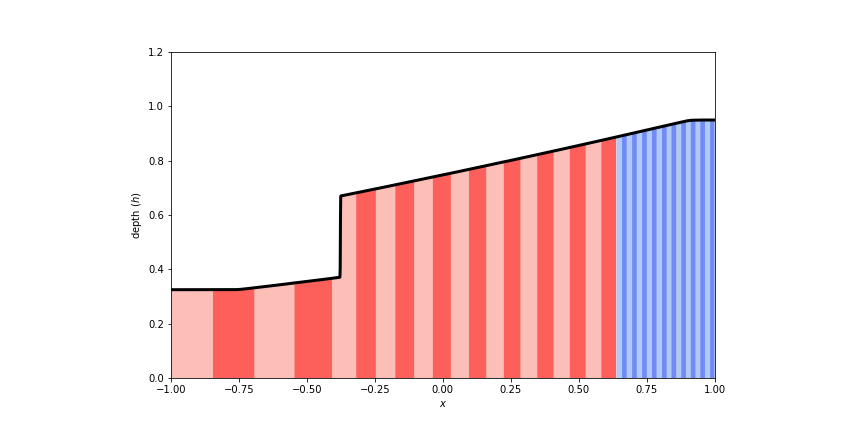
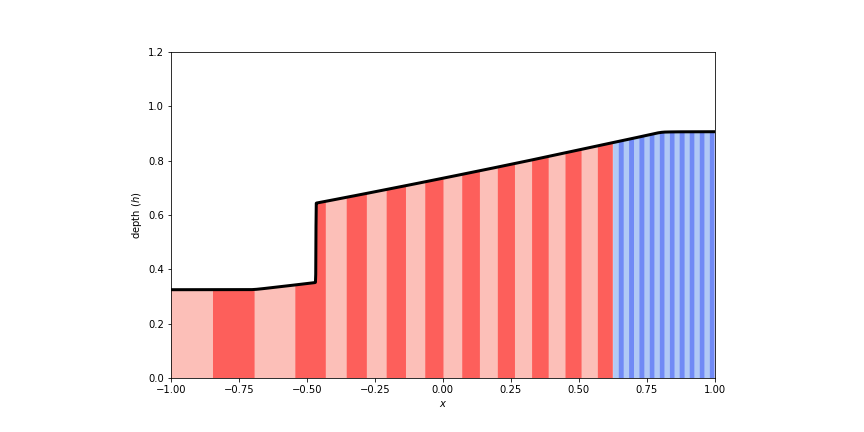
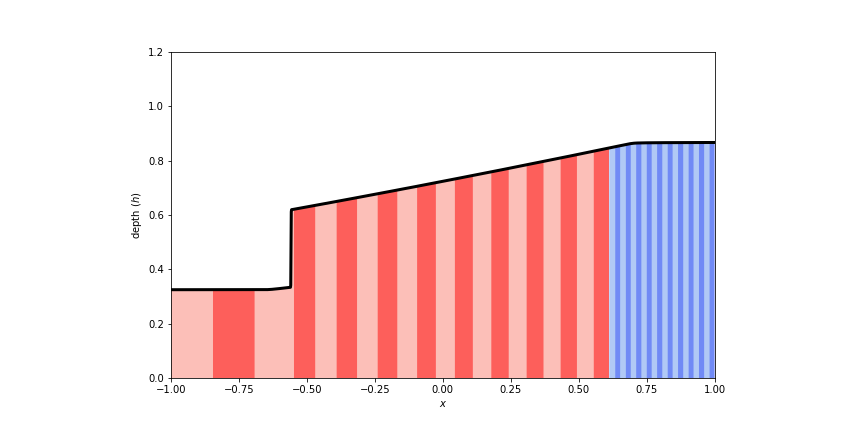
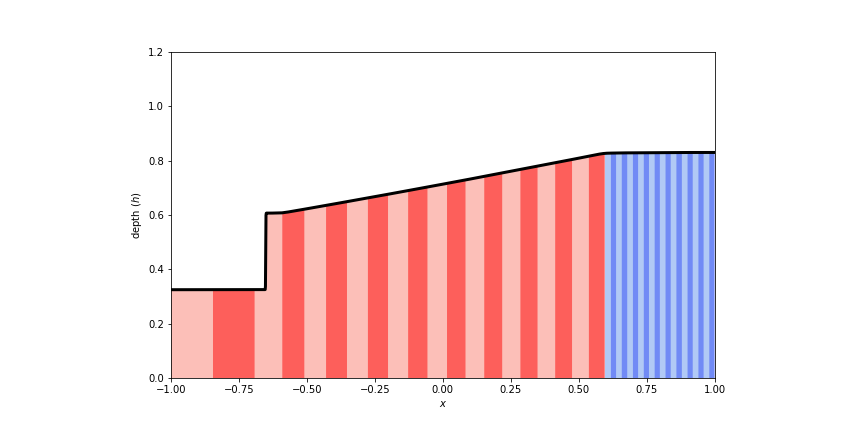
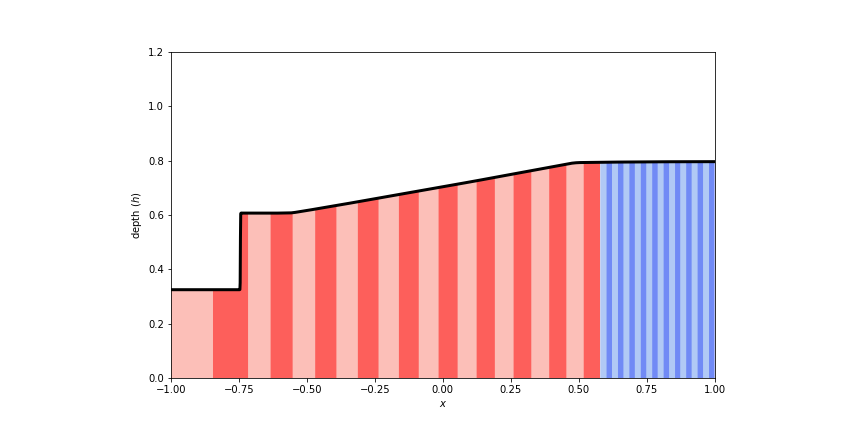
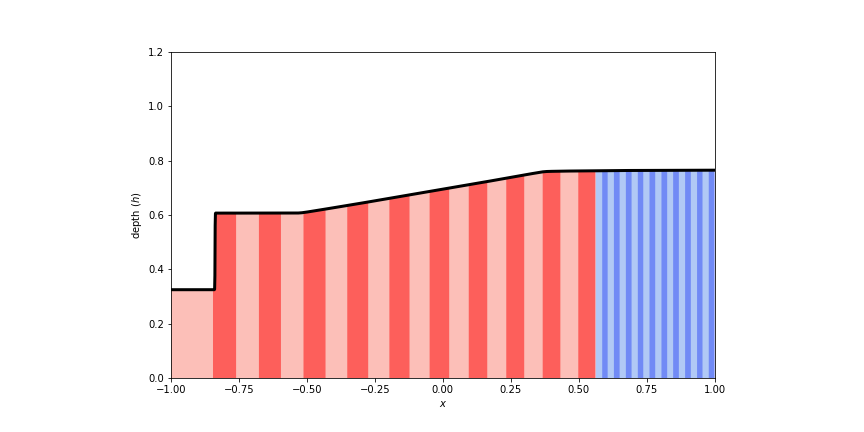
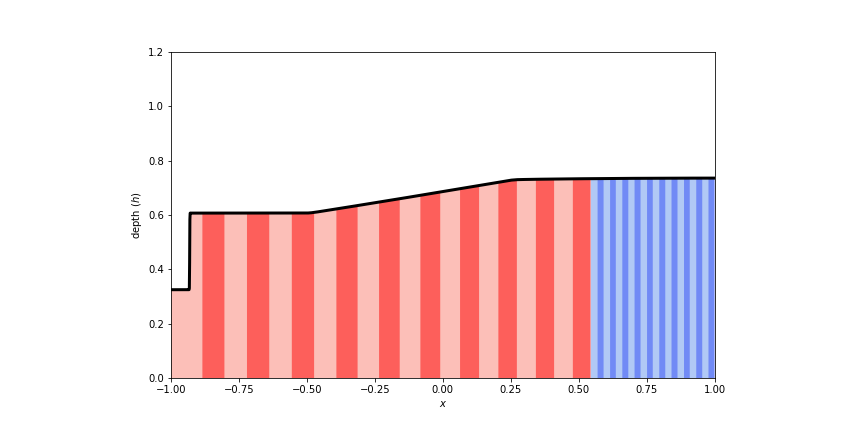
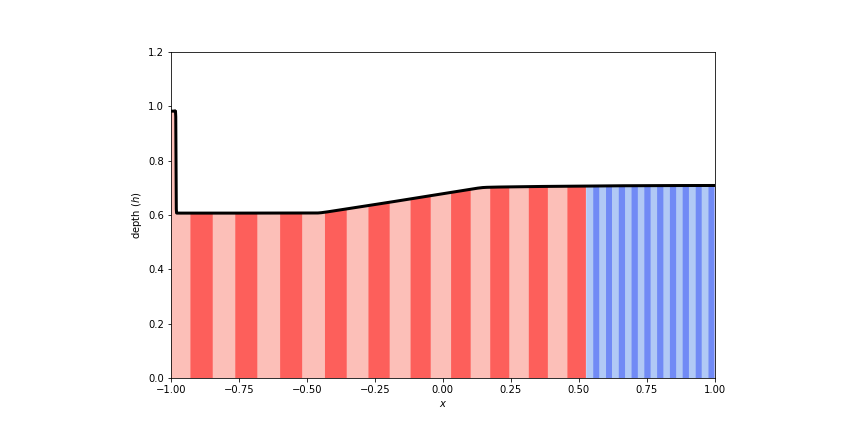
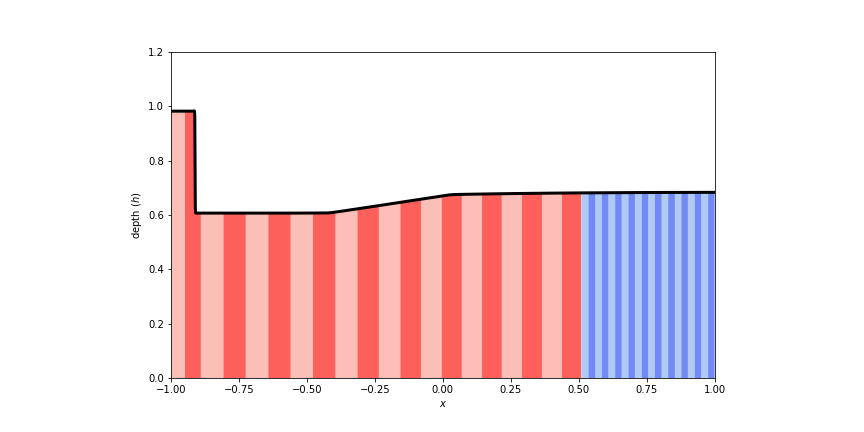
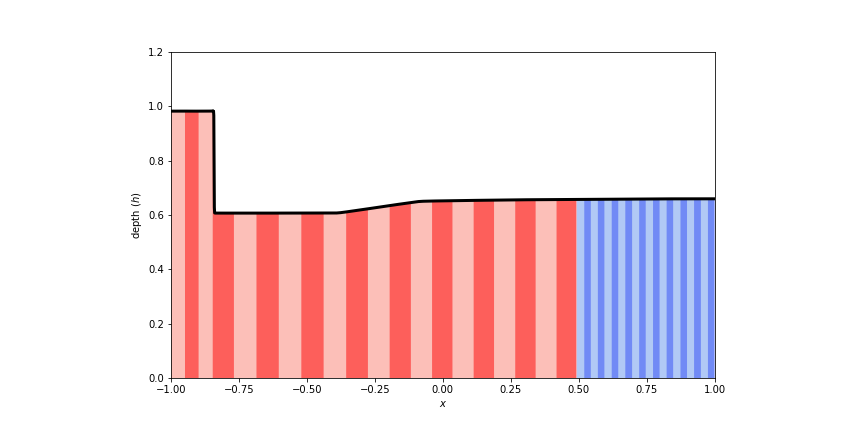
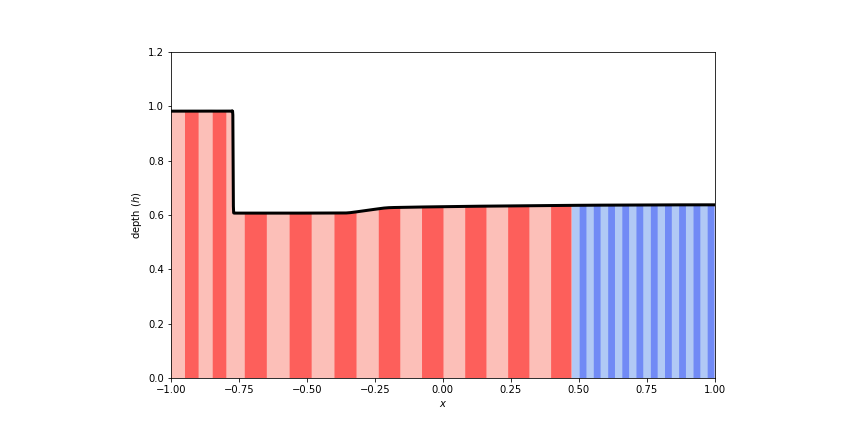
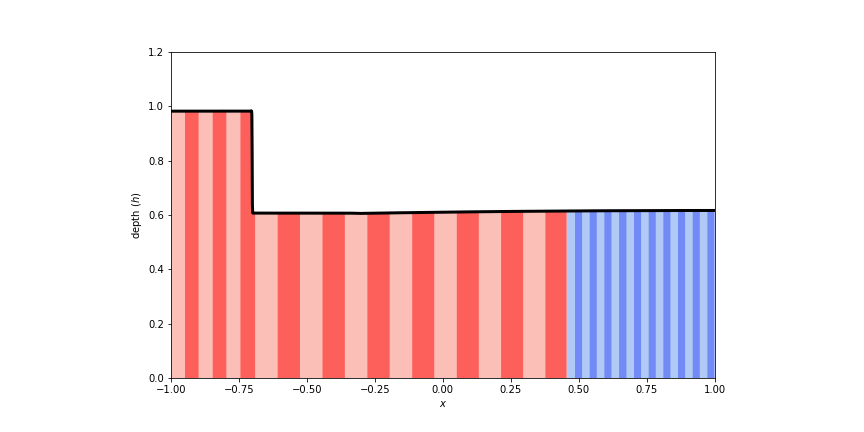
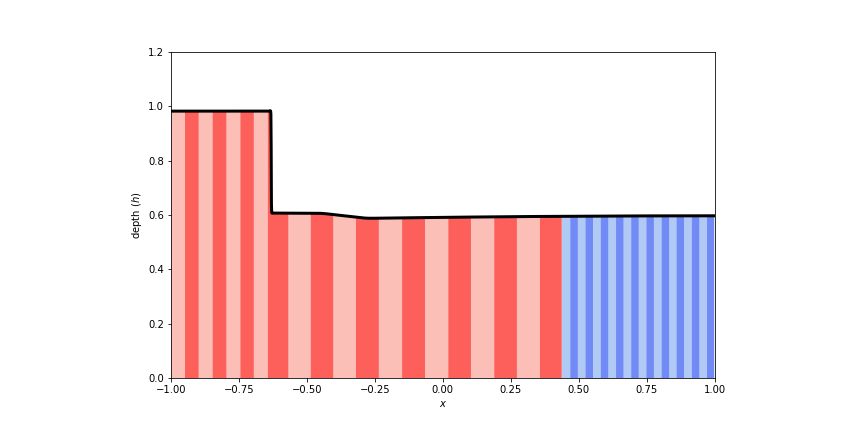
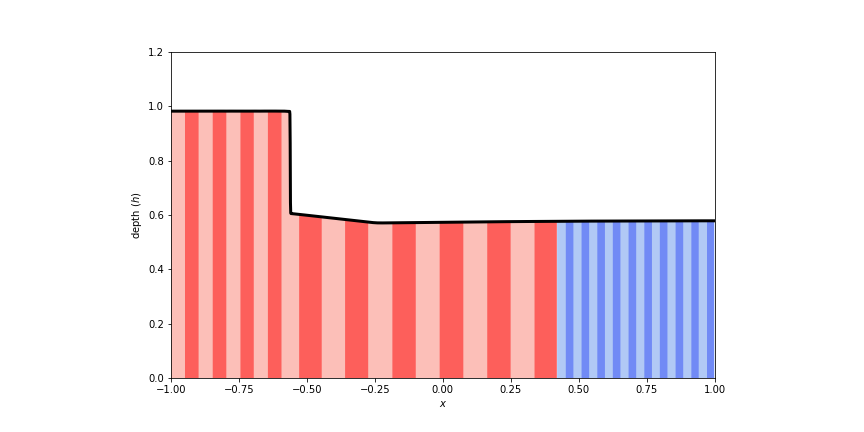
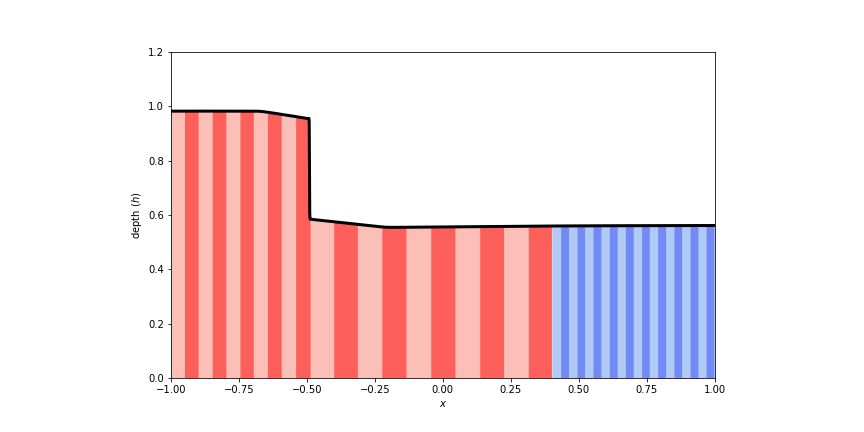
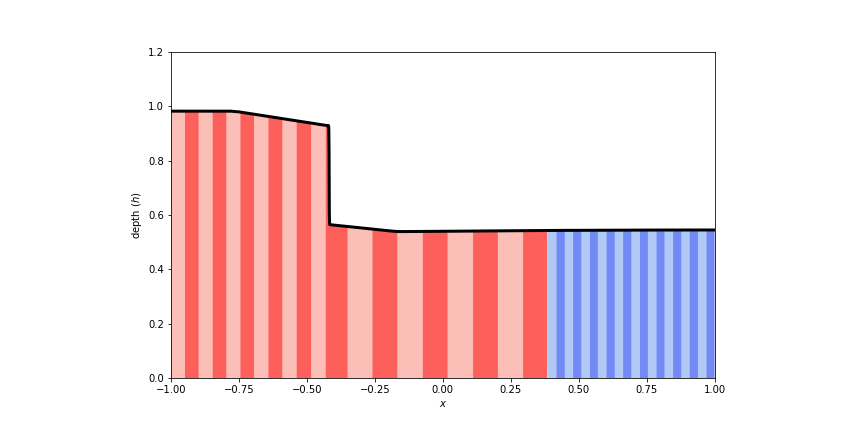
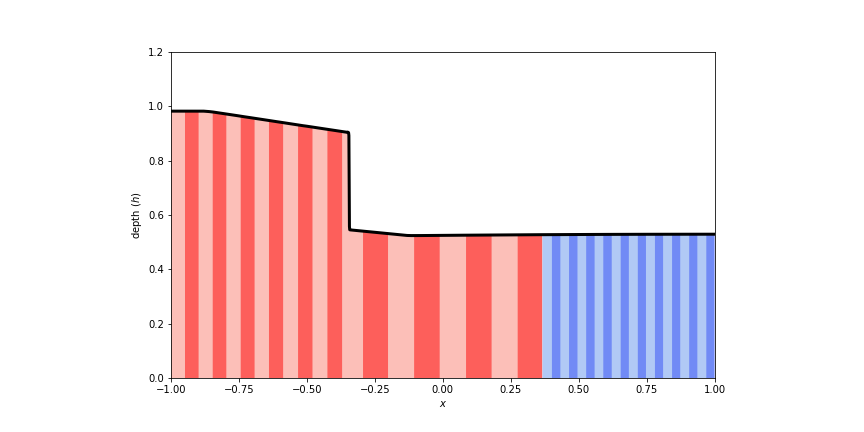
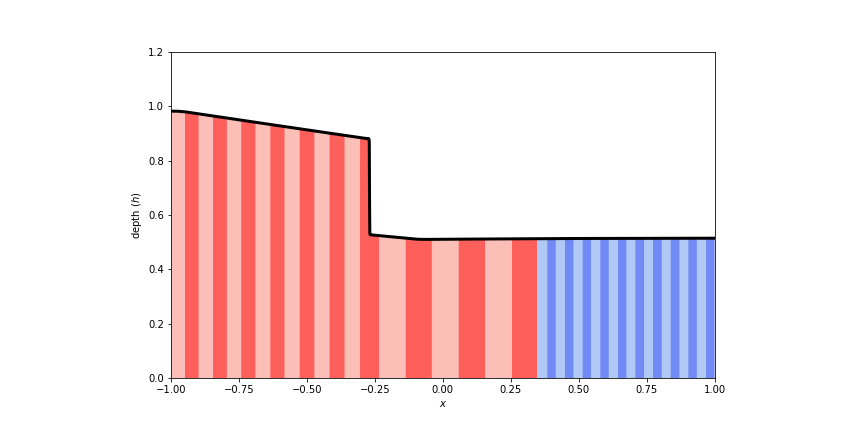
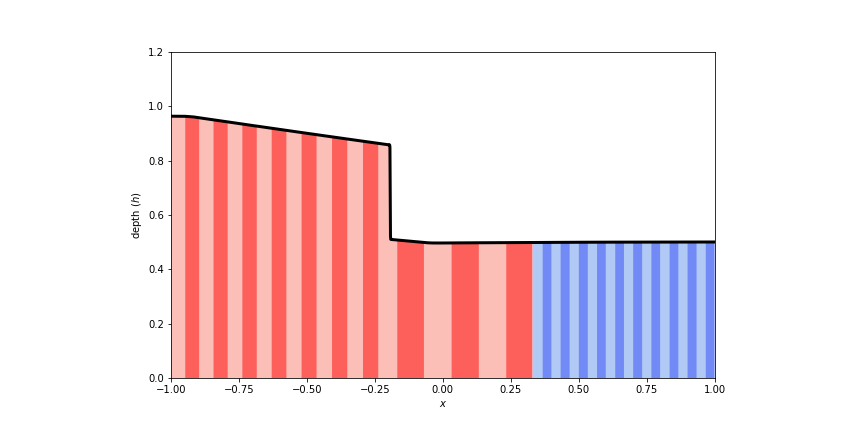
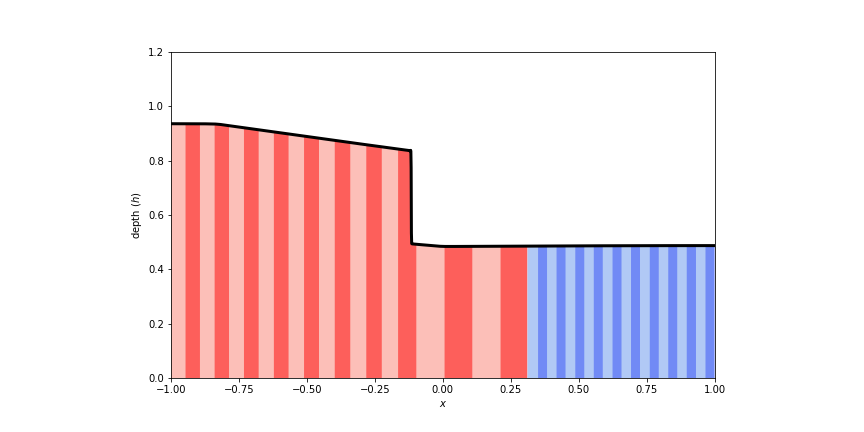
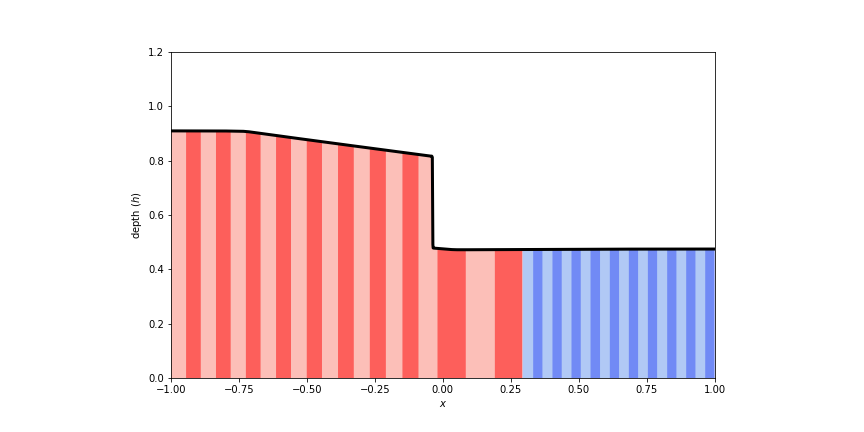
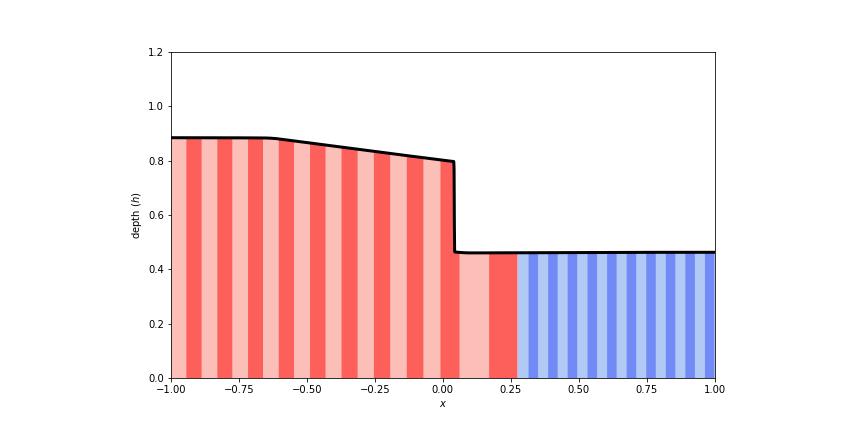

In [3]:
# Plot surface height.  Fill area below surface with alternating dark
# and light stripes that advect with the tracer.
# Red stripes for tracer starting on the left and blue for the right.
# This code is written to include the possibility of a non-zero bathymetry.
# This code should probably be moved to a file in the future.

fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(111)
fills = []
frame = claw.frames[0]
h = frame.q[0,:]
b = 0*h
surface = h+b
tracer = frame.q[2,:]

x, = frame.state.grid.p_centers    

line, = ax.plot(x, surface,'-k',linewidth=3)

fills = {'cornflowerblue': None,
         'blue': None,
         'salmon': None,
         'red': None}
colors = fills.keys()

def set_stripe_regions(tracer):
    # Designate areas for each color of stripe
    stripes = {}
    stripes['cornflowerblue'] = (tracer>=0)
    stripes['blue'] = (tracer%0.1>=0.05)*(tracer>=0)
    stripes['salmon'] = (tracer<=0)
    stripes['red'] = (tracer%0.1>=0.05)*(tracer<=0)
    return stripes

stripes = set_stripe_regions(tracer)

for color in colors:
    fills[color] = ax.fill_between(x,b,surface,facecolor=color,where=stripes[color],alpha=0.5)

plt.xlabel('$x$'); plt.ylabel('depth ($h$)'); plt.axis('scaled')
ax.set_xlim(-1,1); ax.set_ylim(0,1.2)

def fplot(frame_number):
    # Remove old fill_between plots
    for color in colors:
        fills[color].remove()
        
    frame = claw.frames[frame_number]
    h = frame.q[0,:]
    b = 0*h
    tracer = frame.q[2,:]
    surface = h+b
    line.set_data(x,surface)
    stripes = set_stripe_regions(tracer)
    for color in colors:
        fills[color] = ax.fill_between(x,b,surface,facecolor=color,where=stripes[color],alpha=0.5)
    return line,

animation.FuncAnimation(fig, fplot, frames=len(claw.frames), interval=200)

In this animation, note that both the mass of water and quantity of dye in any vertical stripe of a given color is conserved, and that the width of each stripe varies inversely with the depth of water in the stripe.  The edges of the stripes are always moving at the fluid velocity.